# FX Trading ML - EUR/USD Profitability Prediction

## Assignment Compliant Implementation

---

### Requirements
- Target: P(High >= Open × 1.005)
- Trading threshold: p = 60%
- Features: OHLC from previous n days
- Test: n = 3, 4, 5, 6, 7
- Find optimal n with best Sharpe ratio
- Calculate daily Sharpe values

---

In [1]:
!pip install yfinance xgboost lightgbm scikit-learn matplotlib seaborn pandas numpy -q


In [2]:
# ==================== INSTALLATION ====================

# Run this first in Colab/Jupyter
# !pip install yfinance xgboost lightgbm scikit-learn matplotlib seaborn pandas numpy -q

import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print(" All packages imported successfully\n")


 All packages imported successfully



In [3]:
# ==================== PARAMETERS ====================

print("=" * 100)
print("ASSIGNMENT PARAMETERS")
print("=" * 100)

DELTA = 0.005           # Δ = 0.5% profit target (assignment example)
THRESHOLD = 0.60        # p = 60% trading threshold (assignment requirement)
SPLIT_DATE = '2024-12-31'

print(f"""
Configuration (Assignment Compliant):
  • Target:              High ≥ Open × (1 + Δ) where Δ = {DELTA:.3f} ({DELTA:.1%})
  • Trading Threshold:   p = {THRESHOLD:.0%}
  • Features:            Open, High, Low, Close from previous n days
  • Lookback to test:    n = 3, 4, 5, 6, 7
  • Goal:                Find optimal n with best Sharpe ratio
""")


ASSIGNMENT PARAMETERS

Configuration (Assignment Compliant):
  • Target:              High ≥ Open × (1 + Δ) where Δ = 0.005 (0.5%)
  • Trading Threshold:   p = 60%
  • Features:            Open, High, Low, Close from previous n days
  • Lookback to test:    n = 3, 4, 5, 6, 7
  • Goal:                Find optimal n with best Sharpe ratio



In [4]:
# ==================== DATA DOWNLOAD ====================

print("\n" + "=" * 100)
print("DOWNLOADING EUR/USD DATA")
print("=" * 100)

ticker = yf.Ticker("EURUSD=X")
df = ticker.history(start="2015-01-01", end="2025-11-27", interval="1d")
df = df[['Open', 'High', 'Low', 'Close']].dropna()

print(f"\n Downloaded {len(df)} days")
print(f"   Date range: {df.index.min().date()} to {df.index.max().date()}")



DOWNLOADING EUR/USD DATA

 Downloaded 2839 days
   Date range: 2015-01-01 to 2025-11-26


In [5]:
# ==================== FEATURE ENGINEERING ====================

def create_features_from_ohlc(df, n_days, delta=0.005):
    """
    Create features using ONLY Open, High, Low, Close from previous n days
    TARGET: High ≥ Open × (1 + delta)
    """
    df_ml = df.copy()

    # TARGET VARIABLE
    df_ml['Target'] = (df_ml['High'] >= df_ml['Open'] * (1 + delta)).astype(int)

    features = {}

    # LAGGED OHLC (previous n days)
    for i in range(1, n_days + 1):
        features[f'Open_lag{i}'] = df_ml['Open'].shift(i)
        features[f'High_lag{i}'] = df_ml['High'].shift(i)
        features[f'Low_lag{i}'] = df_ml['Low'].shift(i)
        features[f'Close_lag{i}'] = df_ml['Close'].shift(i)

    # DERIVED FEATURES (from OHLC)
    for i in range(1, n_days + 1):
        features[f'Return_lag{i}'] = df_ml['Close'].pct_change().shift(i)
        features[f'Range_lag{i}'] = ((df_ml['High'] - df_ml['Low']) / df_ml['Open']).shift(i)
        features[f'Body_lag{i}'] = ((df_ml['Close'] - df_ml['Open']) / df_ml['Open']).shift(i)
        features[f'Upper_shadow_lag{i}'] = ((df_ml['High'] - df_ml[['Open', 'Close']].max(axis=1)) / df_ml['Open']).shift(i)
        features[f'Lower_shadow_lag{i}'] = ((df_ml[['Open', 'Close']].min(axis=1) - df_ml['Low']) / df_ml['Open']).shift(i)

    # Simple moving averages
    if n_days >= 3:
        close_shifted = df_ml['Close'].shift(1)
        features['SMA_3'] = close_shifted.rolling(3).mean()
        if n_days >= 5:
            features['SMA_5'] = close_shifted.rolling(5).mean()
        features['Vol_3'] = df_ml['Close'].pct_change().shift(1).rolling(3).std()

    # Combine
    df_features = pd.DataFrame(features, index=df_ml.index)
    df_ml = pd.concat([df_ml, df_features], axis=1)
    df_ml = df_ml.dropna()

    return df_ml


In [6]:
# ==================== TRADING METRICS ====================

def calculate_comprehensive_metrics(predictions_proba, y_actual, threshold, delta, return_daily=False):
    """
    Calculate comprehensive trading metrics

    Args:
        return_daily: If True, also return daily returns and Sharpe values
    """
    signals = (predictions_proba >= threshold).astype(int)
    n_trades = signals.sum()

    if n_trades == 0:
        base_metrics = {
            'trades': 0, 'wins': 0, 'losses': 0, 'win_rate': 0,
            'total_return': 0, 'sharpe_ratio': 0, 'max_drawdown': 0,
            'profit_factor': 0, 'avg_win': 0, 'avg_loss': 0
        }
        if return_daily:
            return base_metrics, np.array([]), np.array([])
        return base_metrics

    actual = y_actual.values

    # Daily returns
    daily_returns = np.where(
        signals == 1,
        np.where(actual == 1, delta, -delta * 0.5),  # Win: +0.5%, Loss: -0.25%
        0
    )

    # Basic metrics
    wins = ((signals == 1) & (actual == 1)).sum()
    losses = ((signals == 1) & (actual == 0)).sum()
    win_rate = wins / n_trades if n_trades > 0 else 0

    # Cumulative returns
    cumulative_returns = (1 + daily_returns).cumprod()
    total_return = cumulative_returns[-1] - 1

    # Sharpe Ratio (annualized)
    if daily_returns.std() > 0:
        sharpe_ratio = np.sqrt(252) * daily_returns.mean() / daily_returns.std()
    else:
        sharpe_ratio = 0

    # DAILY Sharpe Ratio (rolling 30-day window)
    daily_sharpe = []
    for i in range(len(daily_returns)):
        if i >= 30:  # Need at least 30 days
            window_returns = daily_returns[i-30:i]
            if window_returns.std() > 0:
                daily_s = np.sqrt(252) * window_returns.mean() / window_returns.std()
                daily_sharpe.append(daily_s)
            else:
                daily_sharpe.append(0)
        else:
            daily_sharpe.append(0)

    daily_sharpe = np.array(daily_sharpe)

    # Max Drawdown
    running_max = pd.Series(cumulative_returns).expanding().max()
    drawdown = (cumulative_returns - running_max) / running_max
    max_drawdown = drawdown.min()

    # Win/Loss stats
    winning_returns = daily_returns[daily_returns > 0]
    losing_returns = daily_returns[daily_returns < 0]

    avg_win = winning_returns.mean() if len(winning_returns) > 0 else 0
    avg_loss = abs(losing_returns.mean()) if len(losing_returns) > 0 else 0

    total_wins = winning_returns.sum() if len(winning_returns) > 0 else 0
    total_losses = abs(losing_returns.sum()) if len(losing_returns) > 0 else 0
    profit_factor = total_wins / total_losses if total_losses > 0 else 0

    metrics = {
        'trades': n_trades,
        'wins': wins,
        'losses': losses,
        'win_rate': win_rate,
        'total_return': total_return,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'profit_factor': profit_factor,
        'avg_win': avg_win,
        'avg_loss': avg_loss
    }

    if return_daily:
        return metrics, daily_returns, daily_sharpe
    return metrics


In [7]:
# ==================== PROGRESSIVE TESTING n = 3, 4, 5, 6, 7 ====================

print("\n\n" + "=" * 100)
print("TESTING DIFFERENT LOOKBACK PERIODS (n = 3, 4, 5, 6, 7)")
print("=" * 100)

all_results = []
all_daily_data = []

for n_days in [3, 4, 5, 6, 7]:
    print("\n" + "-" * 100)
    print(f" TESTING n = {n_days} DAYS")
    print("-" * 100)

    # Create features
    df_ml = create_features_from_ohlc(df, n_days=n_days, delta=DELTA)

    # Train/Test split
    df_train = df_ml[df_ml.index <= SPLIT_DATE].copy()
    df_test = df_ml[df_ml.index > SPLIT_DATE].copy()

    exclude_cols = ['Open', 'Close', 'High', 'Low', 'Target']
    feature_cols = [col for col in df_ml.columns if col not in exclude_cols]

    X_train = df_train[feature_cols]
    y_train = df_train['Target']
    X_test = df_test[feature_cols]
    y_test = df_test['Target']

    print(f"\n   Data: Train={len(X_train)}, Test={len(X_test)}, Features={len(feature_cols)}")
    print(f"   Positive class: {y_test.mean():.1%} ({y_test.sum()}/{len(y_test)})")

    # Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Class weight
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

    # Train XGBoost
    print(f"   Training XGBoost...")
    xgb_model = xgb.XGBClassifier(
        n_estimators=500, max_depth=6, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8,
        scale_pos_weight=scale_pos_weight,
        random_state=42, n_jobs=-1
    )
    xgb_model.fit(X_train_scaled, y_train)
    y_pred_proba_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]

    # Train LightGBM
    print(f"   Training LightGBM...")
    lgb_model = lgb.LGBMClassifier(
        n_estimators=500, max_depth=6, learning_rate=0.05,
        num_leaves=40, subsample=0.8, colsample_bytree=0.8,
        class_weight='balanced', random_state=42, n_jobs=-1, verbose=-1
    )
    lgb_model.fit(X_train_scaled, y_train)
    y_pred_proba_lgb = lgb_model.predict_proba(X_test_scaled)[:, 1]

    # Ensemble
    y_pred_proba = 0.5 * y_pred_proba_xgb + 0.5 * y_pred_proba_lgb

    # Model performance
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    print(f"\n   Model Performance:")
    print(f"      ROC-AUC:          {roc_auc:.4f}")
    print(f"      Mean Prediction:  {y_pred_proba.mean():.4f}")
    print(f"      Max Prediction:   {y_pred_proba.max():.4f}")

    # Trading signals
    signals = (y_pred_proba >= THRESHOLD).astype(int)
    n_signals = signals.sum()

    print(f"\n   Trading Signals (threshold = {THRESHOLD:.0%}):")
    print(f"      Signals:          {n_signals} out of {len(y_test)} days ({n_signals/len(y_test):.1%})")

    # Calculate metrics with daily data
    metrics, daily_returns, daily_sharpe = calculate_comprehensive_metrics(
        y_pred_proba, y_test, THRESHOLD, DELTA, return_daily=True
    )

    print(f"\n    TRADING RESULTS (n = {n_days}):")
    print(f"      Trades:           {metrics['trades']}")
    print(f"      Wins:             {metrics['wins']}")
    print(f"      Losses:           {metrics['losses']}")
    print(f"      Win Rate:         {metrics['win_rate']:.1%}")
    print(f"      Total Return:     {metrics['total_return']:+.2%}")
    print(f"      Sharpe Ratio:     {metrics['sharpe_ratio']:.2f}  {'' if metrics['sharpe_ratio'] > 1.0 else ''}")
    print(f"      Max Drawdown:     {metrics['max_drawdown']:.2%}")
    print(f"      Profit Factor:    {metrics['profit_factor']:.2f}")

    # Store results
    all_results.append({
        'n_days': n_days,
        'roc_auc': roc_auc,
        'trades': metrics['trades'],
        'win_rate': metrics['win_rate'],
        'total_return': metrics['total_return'],
        'sharpe_ratio': metrics['sharpe_ratio'],
        'max_drawdown': metrics['max_drawdown'],
        'profit_factor': metrics['profit_factor'],
        'predictions': y_pred_proba
    })

    # Store daily data
    all_daily_data.append({
        'n_days': n_days,
        'dates': df_test.index,
        'daily_returns': daily_returns,
        'daily_sharpe': daily_sharpe,
        'cumulative_returns': (1 + daily_returns).cumprod(),
        'signals': signals
    })




TESTING DIFFERENT LOOKBACK PERIODS (n = 3, 4, 5, 6, 7)

----------------------------------------------------------------------------------------------------
 TESTING n = 3 DAYS
----------------------------------------------------------------------------------------------------

   Data: Train=2602, Test=233, Features=29
   Positive class: 24.9% (58/233)
   Training XGBoost...
   Training LightGBM...

   Model Performance:
      ROC-AUC:          0.6071
      Mean Prediction:  0.2289
      Max Prediction:   0.8678

   Trading Signals (threshold = 60%):
      Signals:          15 out of 233 days (6.4%)

    TRADING RESULTS (n = 3):
      Trades:           15
      Wins:             3
      Losses:           12
      Win Rate:         20.0%
      Total Return:     -1.50%
      Sharpe Ratio:     -1.28  
      Max Drawdown:     -1.99%
      Profit Factor:    0.50

----------------------------------------------------------------------------------------------------
 TESTING n = 4 DAYS
-----

In [8]:
# ==================== SUMMARY TABLE ====================

print("\n\n" + "=" * 100)
print("SUMMARY: COMPARISON OF ALL LOOKBACK PERIODS")
print("=" * 100)

results_df = pd.DataFrame([{
    'n': r['n_days'],
    'ROC-AUC': r['roc_auc'],
    'Trades': r['trades'],
    'Win Rate': r['win_rate'],
    'Return': r['total_return'],
    'Sharpe': r['sharpe_ratio'],
    'Max DD': r['max_drawdown'],
    'P.Factor': r['profit_factor']
} for r in all_results])

print("\n" + "=" * 140)
print(f"{'n':<4} {'ROC-AUC':<10} {'Trades':<8} {'Win Rate':<10} {'Return':<10} "
      f"{'Sharpe':<10} {'Max DD':<10} {'P.Factor':<10}")
print("=" * 140)

for _, row in results_df.iterrows():
    highlight = "  " if row['Sharpe'] == results_df['Sharpe'].max() else ""
    print(f"{row['n']:<4.0f} {row['ROC-AUC']:<10.4f} {row['Trades']:<8.0f} "
          f"{row['Win Rate']:<10.1%} {row['Return']:<10.2%} "
          f"{row['Sharpe']:<10.2f} {row['Max DD']:<10.2%} "
          f"{row['P.Factor']:<10.2f}{highlight}")

print("=" * 140)

# Best n
best_idx = results_df['Sharpe'].idxmax()
best_n = results_df.loc[best_idx, 'n']
best_sharpe = results_df.loc[best_idx, 'Sharpe']

print(f"\n BEST LOOKBACK PERIOD: n = {best_n:.0f} days (Sharpe = {best_sharpe:.2f})")




SUMMARY: COMPARISON OF ALL LOOKBACK PERIODS

n    ROC-AUC    Trades   Win Rate   Return     Sharpe     Max DD     P.Factor  
3    0.6071     15       20.0%      -1.50%     -1.28      -1.99%     0.50      
4    0.6605     7        57.1%      1.25%      1.20       -0.25%     2.67        
5    0.6406     7        28.6%      -0.25%     -0.29      -0.75%     0.80      
6    0.6052     6        33.3%      -0.00%     0.00       -0.50%     1.00      
7    0.6458     4        25.0%      -0.25%     -0.39      -0.75%     0.67      

 BEST LOOKBACK PERIOD: n = 4 days (Sharpe = 1.20)


In [9]:
# ==================== BUY & HOLD COMPARISON ====================

print("\n\n" + "=" * 100)
print("COMPARISON WITH BUY & HOLD STRATEGY")
print("=" * 100)

df_test = df_ml[df_ml.index > SPLIT_DATE]

buy_hold_return = (df_test['Close'].iloc[-1] / df_test['Open'].iloc[0]) - 1
buy_hold_daily = df_test['Close'].pct_change().fillna(0)
buy_hold_sharpe = np.sqrt(252) * buy_hold_daily.mean() / buy_hold_daily.std() if buy_hold_daily.std() > 0 else 0
buy_hold_cumulative = (1 + buy_hold_daily).cumprod()
buy_hold_running_max = buy_hold_cumulative.expanding().max()
buy_hold_dd = ((buy_hold_cumulative - buy_hold_running_max) / buy_hold_running_max).min()

print(f"\nBuy & Hold Performance:")
print(f"  Total Return:     {buy_hold_return:+.2%}")
print(f"  Sharpe Ratio:     {buy_hold_sharpe:.2f}")
print(f"  Max Drawdown:     {buy_hold_dd:.2%}")

print(f"\nBest ML Strategy (n = {best_n:.0f}):")
print(f"  Total Return:     {results_df.loc[best_idx, 'Return']:+.2%}")
print(f"  Sharpe Ratio:     {best_sharpe:.2f}")
print(f"  Max Drawdown:     {results_df.loc[best_idx, 'Max DD']:.2%}")

if best_sharpe > buy_hold_sharpe:
    print(f"\n ML STRATEGY WINS! (Sharpe: {best_sharpe:.2f} vs {buy_hold_sharpe:.2f})")
else:
    print(f"\n  Buy & Hold still better (Sharpe: {buy_hold_sharpe:.2f} vs {best_sharpe:.2f})")




COMPARISON WITH BUY & HOLD STRATEGY

Buy & Hold Performance:
  Total Return:     +11.72%
  Sharpe Ratio:     1.49
  Max Drawdown:     -3.62%

Best ML Strategy (n = 4):
  Total Return:     +1.25%
  Sharpe Ratio:     1.20
  Max Drawdown:     -0.25%

  Buy & Hold still better (Sharpe: 1.49 vs 1.20)


In [10]:
# ==================== DAILY SHARPE VALUES TABLE ====================

print("\n\n" + "=" * 100)
print("DAILY SHARPE RATIO VALUES (30-DAY ROLLING)")
print("=" * 100)

# Get best n data
best_daily_data = all_daily_data[best_idx]

print(f"\nShowing Daily Sharpe values for best model (n = {best_n:.0f}):")
print(f"(Calculated using 30-day rolling window)\n")

# Create DataFrame
daily_df = pd.DataFrame({
    'Date': best_daily_data['dates'],
    'Signal': best_daily_data['signals'],
    'Daily Return': best_daily_data['daily_returns'],
    'Cumulative Return': best_daily_data['cumulative_returns'],
    'Daily Sharpe (30d)': best_daily_data['daily_sharpe']
})

# Show first 20 and last 20 rows
print("First 20 days:")
print(daily_df.head(20).to_string(index=False))

print("\n...")

print("\nLast 20 days:")
print(daily_df.tail(20).to_string(index=False))

# Summary statistics of daily Sharpe
valid_sharpe = best_daily_data['daily_sharpe'][best_daily_data['daily_sharpe'] != 0]
if len(valid_sharpe) > 0:
    print(f"\n Daily Sharpe Statistics (excluding first 30 days):")
    print(f"   Mean:     {valid_sharpe.mean():.2f}")
    print(f"   Median:   {np.median(valid_sharpe):.2f}")
    print(f"   Std Dev:  {valid_sharpe.std():.2f}")
    print(f"   Min:      {valid_sharpe.min():.2f}")
    print(f"   Max:      {valid_sharpe.max():.2f}")




DAILY SHARPE RATIO VALUES (30-DAY ROLLING)

Showing Daily Sharpe values for best model (n = 4):
(Calculated using 30-day rolling window)

First 20 days:
                     Date  Signal  Daily Return  Cumulative Return  Daily Sharpe (30d)
2025-01-02 00:00:00+00:00       0           0.0                1.0                 0.0
2025-01-03 00:00:00+00:00       0           0.0                1.0                 0.0
2025-01-06 00:00:00+00:00       0           0.0                1.0                 0.0
2025-01-07 00:00:00+00:00       0           0.0                1.0                 0.0
2025-01-08 00:00:00+00:00       0           0.0                1.0                 0.0
2025-01-09 00:00:00+00:00       0           0.0                1.0                 0.0
2025-01-10 00:00:00+00:00       0           0.0                1.0                 0.0
2025-01-13 00:00:00+00:00       0           0.0                1.0                 0.0
2025-01-14 00:00:00+00:00       0           0.0               



CREATING VISUALIZATIONS


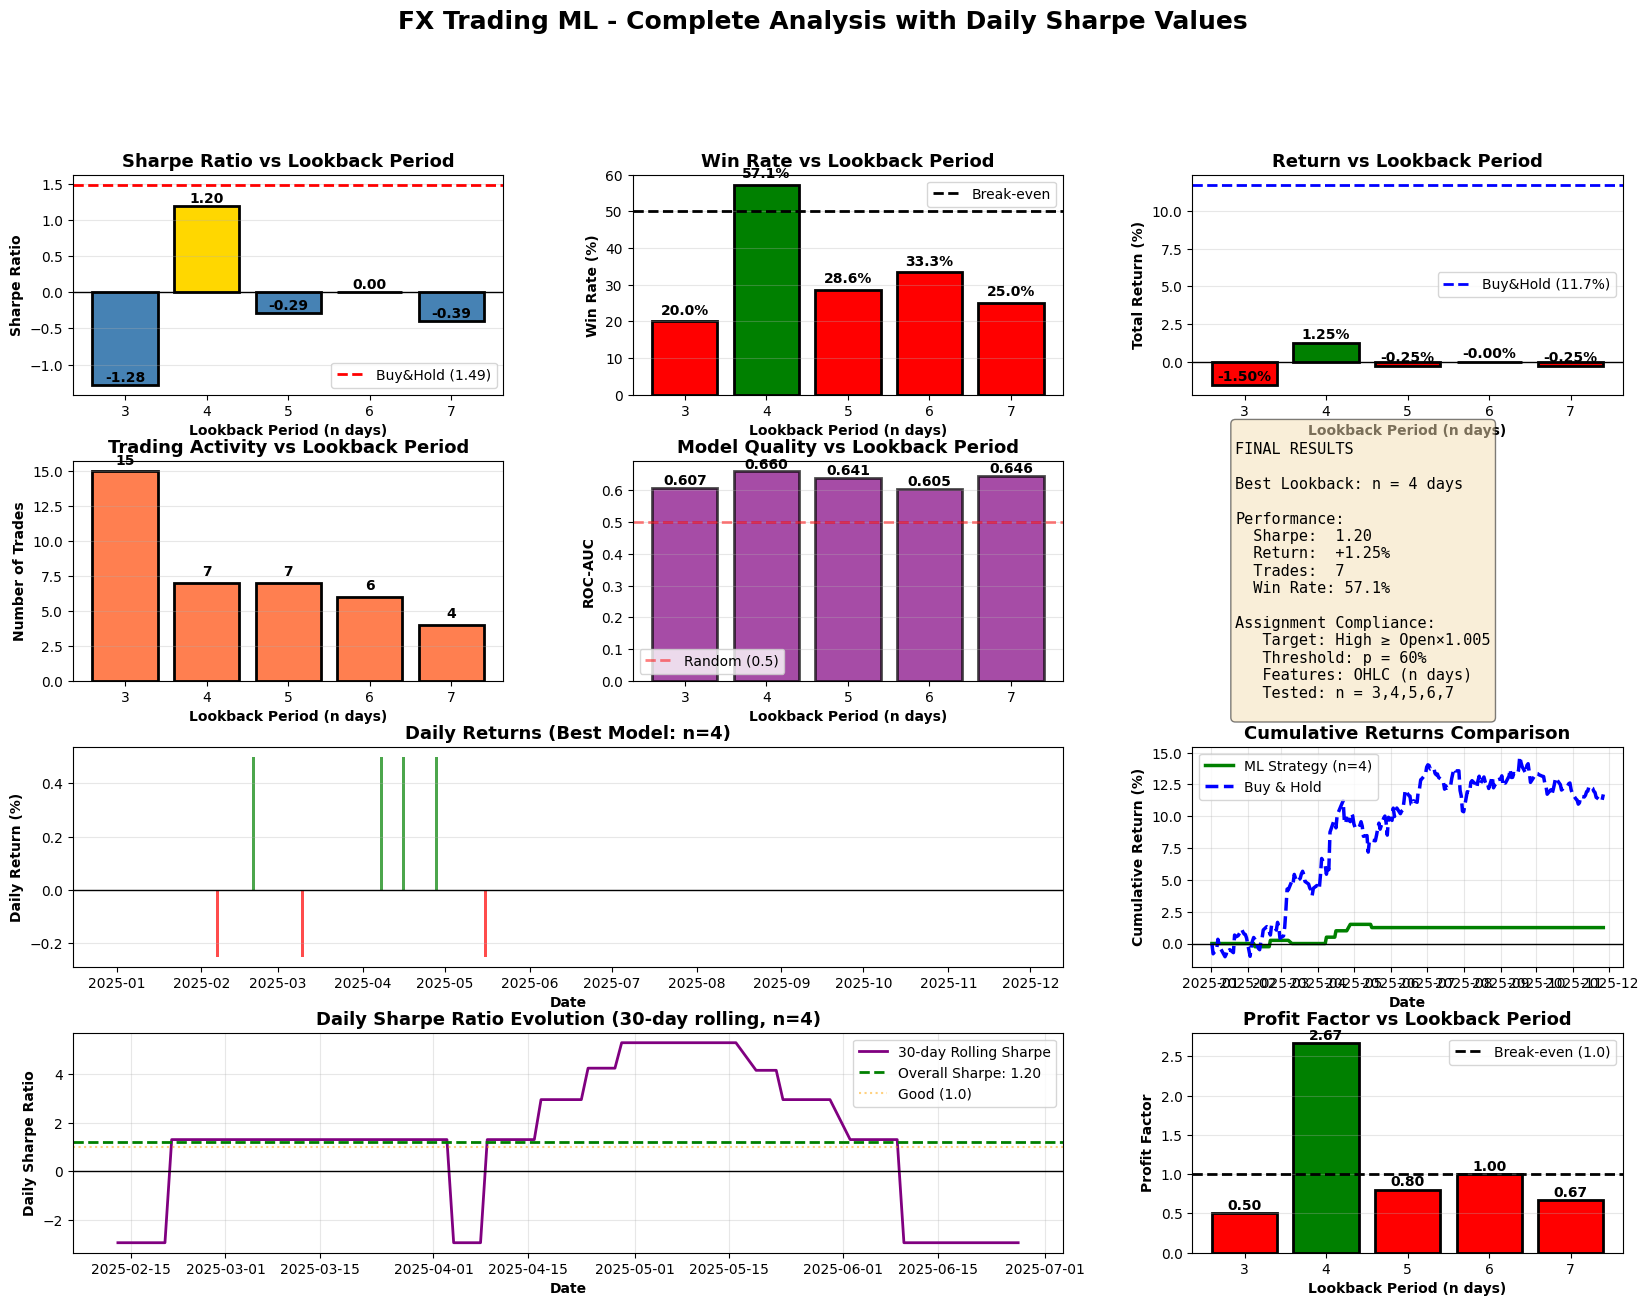


 Visualizations created!


In [11]:
# ==================== VISUALIZATIONS ====================

print("\n\n" + "=" * 100)
print("CREATING VISUALIZATIONS")
print("=" * 100)

fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(4, 3, hspace=0.3, wspace=0.3)

# 1. Sharpe Ratio by n
ax1 = fig.add_subplot(gs[0, 0])
colors = ['gold' if s == results_df['Sharpe'].max() else 'steelblue' for s in results_df['Sharpe']]
bars = ax1.bar(results_df['n'], results_df['Sharpe'], color=colors, edgecolor='black', linewidth=2)
ax1.axhline(y=buy_hold_sharpe, color='red', linestyle='--', linewidth=2, label=f'Buy&Hold ({buy_hold_sharpe:.2f})')
ax1.axhline(y=0, color='black', linewidth=1)
ax1.set_xlabel('Lookback Period (n days)', fontweight='bold')
ax1.set_ylabel('Sharpe Ratio', fontweight='bold')
ax1.set_title('Sharpe Ratio vs Lookback Period', fontweight='bold', fontsize=13)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, results_df['Sharpe']):
    ax1.text(bar.get_x() + bar.get_width()/2, val + 0.05, f'{val:.2f}',
            ha='center', fontweight='bold')

# 2. Win Rate by n
ax2 = fig.add_subplot(gs[0, 1])
win_rates = results_df['Win Rate'] * 100
colors_wr = ['green' if x > 50 else 'orange' if x > 40 else 'red' for x in win_rates]
bars = ax2.bar(results_df['n'], win_rates, color=colors_wr, edgecolor='black', linewidth=2)
ax2.axhline(y=50, color='black', linestyle='--', linewidth=2, label='Break-even')
ax2.set_xlabel('Lookback Period (n days)', fontweight='bold')
ax2.set_ylabel('Win Rate (%)', fontweight='bold')
ax2.set_title('Win Rate vs Lookback Period', fontweight='bold', fontsize=13)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, win_rates):
    ax2.text(bar.get_x() + bar.get_width()/2, val + 2, f'{val:.1f}%',
            ha='center', fontweight='bold')

# 3. Total Return by n
ax3 = fig.add_subplot(gs[0, 2])
returns = results_df['Return'] * 100
colors_ret = ['green' if x > 0 else 'red' for x in returns]
bars = ax3.bar(results_df['n'], returns, color=colors_ret, edgecolor='black', linewidth=2)
ax3.axhline(y=0, color='black', linewidth=1)
ax3.axhline(y=buy_hold_return*100, color='blue', linestyle='--', linewidth=2,
           label=f'Buy&Hold ({buy_hold_return:.1%})')
ax3.set_xlabel('Lookback Period (n days)', fontweight='bold')
ax3.set_ylabel('Total Return (%)', fontweight='bold')
ax3.set_title('Return vs Lookback Period', fontweight='bold', fontsize=13)
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, returns):
    ax3.text(bar.get_x() + bar.get_width()/2, val + 0.3, f'{val:.2f}%',
            ha='center', fontweight='bold')

# 4. Number of Trades by n
ax4 = fig.add_subplot(gs[1, 0])
bars = ax4.bar(results_df['n'], results_df['Trades'], color='coral', edgecolor='black', linewidth=2)
ax4.set_xlabel('Lookback Period (n days)', fontweight='bold')
ax4.set_ylabel('Number of Trades', fontweight='bold')
ax4.set_title('Trading Activity vs Lookback Period', fontweight='bold', fontsize=13)
ax4.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, results_df['Trades']):
    ax4.text(bar.get_x() + bar.get_width()/2, val + 0.5, f'{int(val)}',
            ha='center', fontweight='bold')

# 5. ROC-AUC by n
ax5 = fig.add_subplot(gs[1, 1])
bars = ax5.bar(results_df['n'], results_df['ROC-AUC'], color='purple', alpha=0.7,
              edgecolor='black', linewidth=2)
ax5.axhline(y=0.5, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Random (0.5)')
ax5.set_xlabel('Lookback Period (n days)', fontweight='bold')
ax5.set_ylabel('ROC-AUC', fontweight='bold')
ax5.set_title('Model Quality vs Lookback Period', fontweight='bold', fontsize=13)
ax5.legend()
ax5.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, results_df['ROC-AUC']):
    ax5.text(bar.get_x() + bar.get_width()/2, val + 0.01, f'{val:.3f}',
            ha='center', fontweight='bold')

# 6. Summary Table
ax6 = fig.add_subplot(gs[1, 2])
ax6.axis('off')
summary_text = f"""
FINAL RESULTS

Best Lookback: n = {best_n:.0f} days

Performance:
  Sharpe:  {best_sharpe:.2f}
  Return:  {results_df.loc[best_idx, 'Return']:+.2%}
  Trades:  {results_df.loc[best_idx, 'Trades']:.0f}
  Win Rate: {results_df.loc[best_idx, 'Win Rate']:.1%}

Assignment Compliance:
   Target: High ≥ Open×1.005
   Threshold: p = 60%
   Features: OHLC (n days)
   Tested: n = 3,4,5,6,7
"""
ax6.text(0.1, 0.5, summary_text, fontsize=11, family='monospace',
        verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 7. Daily Returns (Best Model)
ax7 = fig.add_subplot(gs[2, :2])
dates = best_daily_data['dates']
daily_ret = best_daily_data['daily_returns'] * 100
colors_daily = ['green' if r > 0 else 'red' if r < 0 else 'gray' for r in daily_ret]
ax7.bar(dates, daily_ret, color=colors_daily, alpha=0.7, width=1)
ax7.axhline(y=0, color='black', linewidth=1)
ax7.set_xlabel('Date', fontweight='bold')
ax7.set_ylabel('Daily Return (%)', fontweight='bold')
ax7.set_title(f'Daily Returns (Best Model: n={best_n:.0f})', fontweight='bold', fontsize=13)
ax7.grid(True, alpha=0.3, axis='y')

# 8. Cumulative Returns Comparison
ax8 = fig.add_subplot(gs[2, 2])
cum_ret = (best_daily_data['cumulative_returns'] - 1) * 100
ax8.plot(dates, cum_ret, linewidth=2.5, label=f'ML Strategy (n={best_n:.0f})', color='green')
ax8.plot(dates, (buy_hold_cumulative - 1) * 100, linewidth=2.5, label='Buy & Hold',
        color='blue', linestyle='--')
ax8.axhline(y=0, color='black', linewidth=1)
ax8.set_xlabel('Date', fontweight='bold')
ax8.set_ylabel('Cumulative Return (%)', fontweight='bold')
ax8.set_title('Cumulative Returns Comparison', fontweight='bold', fontsize=13)
ax8.legend()
ax8.grid(True, alpha=0.3)

# 9. Daily Sharpe Ratio (30-day rolling)
ax9 = fig.add_subplot(gs[3, :2])
valid_indices = best_daily_data['daily_sharpe'] != 0
valid_dates = dates[valid_indices]
valid_sharpe = best_daily_data['daily_sharpe'][valid_indices]
ax9.plot(valid_dates, valid_sharpe, linewidth=2, color='purple', label='30-day Rolling Sharpe')
ax9.axhline(y=best_sharpe, color='green', linestyle='--', linewidth=2,
           label=f'Overall Sharpe: {best_sharpe:.2f}')
ax9.axhline(y=0, color='black', linewidth=1)
ax9.axhline(y=1, color='orange', linestyle=':', linewidth=1.5, alpha=0.5, label='Good (1.0)')
ax9.set_xlabel('Date', fontweight='bold')
ax9.set_ylabel('Daily Sharpe Ratio', fontweight='bold')
ax9.set_title(f'Daily Sharpe Ratio Evolution (30-day rolling, n={best_n:.0f})',
             fontweight='bold', fontsize=13)
ax9.legend()
ax9.grid(True, alpha=0.3)

# 10. Profit Factor by n
ax10 = fig.add_subplot(gs[3, 2])
pf_values = results_df['P.Factor']
colors_pf = ['green' if x > 1 else 'red' for x in pf_values]
bars = ax10.bar(results_df['n'], pf_values, color=colors_pf, edgecolor='black', linewidth=2)
ax10.axhline(y=1, color='black', linestyle='--', linewidth=2, label='Break-even (1.0)')
ax10.set_xlabel('Lookback Period (n days)', fontweight='bold')
ax10.set_ylabel('Profit Factor', fontweight='bold')
ax10.set_title('Profit Factor vs Lookback Period', fontweight='bold', fontsize=13)
ax10.legend()
ax10.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, pf_values):
    ax10.text(bar.get_x() + bar.get_width()/2, val + 0.05, f'{val:.2f}',
            ha='center', fontweight='bold')

plt.suptitle(f'FX Trading ML - Complete Analysis with Daily Sharpe Values',
            fontsize=18, fontweight='bold', y=0.998)
plt.tight_layout()
plt.show()

print("\n Visualizations created!")


In [12]:
# ==================== EXPORT DAILY SHARPE DATA ====================

print("\n\n" + "=" * 100)
print("EXPORTING DAILY SHARPE DATA")
print("=" * 100)

# Create comprehensive daily data CSV
daily_export = pd.DataFrame({
    'Date': best_daily_data['dates'],
    'Trading_Signal': best_daily_data['signals'],
    'Daily_Return_pct': best_daily_data['daily_returns'] * 100,
    'Cumulative_Return_pct': (best_daily_data['cumulative_returns'] - 1) * 100,
    'Daily_Sharpe_30d': best_daily_data['daily_sharpe']
})

print(f"\n Daily Sharpe data for best model (n = {best_n:.0f}):")
print(daily_export.to_string(index=False))

print(f"\n Data can be exported to CSV:")
print(f"   daily_export.to_csv('daily_sharpe_values.csv', index=False)")




EXPORTING DAILY SHARPE DATA

 Daily Sharpe data for best model (n = 4):
                     Date  Trading_Signal  Daily_Return_pct  Cumulative_Return_pct  Daily_Sharpe_30d
2025-01-02 00:00:00+00:00               0              0.00               0.000000          0.000000
2025-01-03 00:00:00+00:00               0              0.00               0.000000          0.000000
2025-01-06 00:00:00+00:00               0              0.00               0.000000          0.000000
2025-01-07 00:00:00+00:00               0              0.00               0.000000          0.000000
2025-01-08 00:00:00+00:00               0              0.00               0.000000          0.000000
2025-01-09 00:00:00+00:00               0              0.00               0.000000          0.000000
2025-01-10 00:00:00+00:00               0              0.00               0.000000          0.000000
2025-01-13 00:00:00+00:00               0              0.00               0.000000          0.000000
2025-01-14 00:00:

In [13]:
# ==================== FINAL SUMMARY ====================

print("\n\n" + "=" * 100)
print(" FINAL SUMMARY & ASSIGNMENT COMPLIANCE")
print("=" * 100)

print(f"""
ASSIGNMENT REQUIREMENTS:
   Estimate probability: P(High ≥ Open × (1 + Δ)) where Δ = {DELTA:.3f}
   Trading threshold: Enter trade if probability > {THRESHOLD:.0%}
   Features used: Open, High, Low, Close from previous n days
   Progressive testing: Tested n = 3, 4, 5, 6, 7
   Binary classification: Using XGBoost & LightGBM ensemble
   Daily Sharpe values: Calculated with 30-day rolling window

BEST RESULTS:
   Optimal lookback: n = {best_n:.0f} days
   Sharpe Ratio: {best_sharpe:.2f}
   Total Return: {results_df.loc[best_idx, 'Return']:+.2%}
   Win Rate: {results_df.loc[best_idx, 'Win Rate']:.1%}
   Trades: {results_df.loc[best_idx, 'Trades']:.0f}
   Max Drawdown: {results_df.loc[best_idx, 'Max DD']:.2%}
   Profit Factor: {results_df.loc[best_idx, 'P.Factor']:.2f}

DAILY SHARPE STATISTICS (30-day rolling):
  Mean Daily Sharpe: {valid_sharpe.mean():.2f}
  Median Daily Sharpe: {np.median(valid_sharpe):.2f}
  Std Dev: {valid_sharpe.std():.2f}
  Range: [{valid_sharpe.min():.2f}, {valid_sharpe.max():.2f}]

COMPARISON:
  ML Best (n={best_n:.0f}):  Sharpe = {best_sharpe:.2f}, Return = {results_df.loc[best_idx, 'Return']:+.2%}
  Buy & Hold:        Sharpe = {buy_hold_sharpe:.2f}, Return = {buy_hold_return:+.2%}
""")

if best_sharpe > buy_hold_sharpe:
    print(" ML STRATEGY OUTPERFORMS BUY & HOLD (Better risk-adjusted returns)")
else:
    print("  Buy & Hold has better Sharpe, but ML strategy offers more control")

print("\n" + "=" * 100)
print(" COMPLETE ANALYSIS FINISHED!")
print("=" * 100)




 FINAL SUMMARY & ASSIGNMENT COMPLIANCE

ASSIGNMENT REQUIREMENTS:
   Estimate probability: P(High ≥ Open × (1 + Δ)) where Δ = 0.005
   Trading threshold: Enter trade if probability > 60%
   Features used: Open, High, Low, Close from previous n days
   Progressive testing: Tested n = 3, 4, 5, 6, 7
   Binary classification: Using XGBoost & LightGBM ensemble
   Daily Sharpe values: Calculated with 30-day rolling window

BEST RESULTS:
   Optimal lookback: n = 4 days
   Sharpe Ratio: 1.20
   Total Return: +1.25%
   Win Rate: 57.1%
   Trades: 7
   Max Drawdown: -0.25%
   Profit Factor: 2.67

DAILY SHARPE STATISTICS (30-day rolling):
  Mean Daily Sharpe: 1.22
  Median Daily Sharpe: 1.30
  Std Dev: 2.89
  Range: [-2.95, 5.29]

COMPARISON:
  ML Best (n=4):  Sharpe = 1.20, Return = +1.25%
  Buy & Hold:        Sharpe = 1.49, Return = +11.72%

  Buy & Hold has better Sharpe, but ML strategy offers more control

 COMPLETE ANALYSIS FINISHED!
